#Benchmarking Performance and Scaling of Python Clustering Algorithms

There are a host of different clustering algorithms and implementations thereof for Python. The performance and scaling can depend as much on the implementation as the underlying algorithm. Obviously a well written implementation in C or C++ will beat a naive implementation on pure Python, but there is more to it than just that. The internals and data structures used can have a large impact on performance, and can even significanty change asymptotic performance. All of this means that, given some amount of data that you want to cluster your options as to algorithm and implementation maybe significantly constrained. I'm both lazy, and prefer empirical results for this sort of thing, so rather than analyzing the implementations and deriving asymptotic performance numbers for various implementations I'm just going to run everything and see what happens.

To begin with we need to get together all the clustering implementations, along with some plotting libraries so we can see what is going on once we've got data. Obviously this is not an exhaustive collection of clustering implementations, so if I've left off your favourite I apologise, but one has to draw a line somewhere.

The implementations being test are:

* [Sklearn](http://scikit-learn.org/stable/modules/clustering.html) (which implements several algorithms):
 * K-Means clustering
 * DBSCAN clustering
 * Agglomerative clustering
 * Spectral clustering
 * Affinity Propagation
* [Scipy](http://docs.scipy.org/doc/scipy/reference/cluster.html) (which provides basic algorithms):
 * K-Means clustering
 * Agglomerative clustering
* [Fastcluster](http://danifold.net/fastcluster.html) (which provides very fast agglomerative clustering in C++)
* [DeBaCl](https://github.com/CoAxLab/DeBaCl) (Density Based Clustering; similar to a mix of DBSCAN and Agglomerative)
* [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan) (A robust hierarchical version of DBSCAN)

Obviously a major factor in performance will be the algorithm itself. Some algorithms are simply slower -- often, but not always, because they are doing more work to provide a better clustering.

In [1]:
import hdbscan
import debacl
import fastcluster
import sklearn.cluster
import scipy.cluster
import sklearn.datasets
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Now we need some benchmarking code at various dataset sizes. Because some clustering algorithms have performance that can vary quite a lot depending on the exact nature of the dataset we'll also need to run several times on randomly generated datasets of each size so as to get a better idea of the average case performance.

We also need to generalise over algorithms which don't necessarily all have the same API. We can resolve that by taking a clustering function, argument tuple and keywords dictionary to let us do semi-arbitrary calls (fortunately all the algorithms do at least take the dataset to cluster as the first parameter).

Finally some algorithms scale poorly, and I don't want to spend forever doing clustering of random datasets so we'll cap the maximum time an algorithm can use; once it has taken longer than max time we'll just abort there and leave the remaining entries in our datasize by samples matrix unfilled.

In the end this all amounts to a fairly straightforward set of nested loops (over datasizes and number of samples) with calls to sklearn to generate mock data and the clustering function inside a timer. Add in some early abort and we're done.

In [2]:
def benchmark_algorithm(dataset_sizes, cluster_function, function_args, function_kwds,
                        dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):
    
    # Initialize the result with NaNs so that any unfilled entries 
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=size, 
                                                       n_features=dataset_dimension, 
                                                       centers=dataset_n_clusters)
            
            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time
            
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size), 
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken
        
    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size), 
                                   result.flatten()]).T, columns=['x','y'])

## Comparison of all ten implementations

Now we need a range of dataset sizes to test out our algorithm. Since the scaling performance is wildly different over the ten implementations we're going to look at it will be beneficial to have a number of very small dataset sizes, and increasing spacing as we get larger, spanning out to 32000 datapoints to cluster (to begin with). Numpy provides convenient ways to get this done via `arange` and vector multiplication. We'll start with step sizes of 500, then shift to steps of 1000 past 3000 datapoints, and finally steps of 2000 past 6000 datapoints.

In [3]:
dataset_sizes = np.hstack([np.arange(1, 6) * 500, np.arange(3,7) * 1000, np.arange(4,17) * 2000])

Now it is just a matter of running all the clustering algorithms via our benchmark function to collect up all the requsite data. This could be prettier, rolled up into functions appropriately, but sometimes brute force is good enough. More importantly (for me) since this can take a significant amount of compute time, I wanted to be able to comment out algorithms that were slow or I was uninterested in easily. Which brings me to a warning for you the reader and potential user of the notebook: this next step is very expensive. We are running ten different clustering algorithms multiple times each on twenty two different dataset sizes -- and some of the clustering algorithms are slow (we are capping out at forty five seconds per run). That means that the next cell can take an hour or more to run. That doesn't mean "Don't try this at home" (I actually encourage you to try this out yourself and play with dataset parameters and clustering parameters) but it does mean you should be patient if you're going to!

In [4]:
k_means = sklearn.cluster.KMeans(10)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})

dbscan = sklearn.cluster.DBSCAN(eps=1.25)
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})

scipy_k_means_data = benchmark_algorithm(dataset_sizes, 
                                         scipy.cluster.vq.kmeans, (10,), {})

scipy_single_data = benchmark_algorithm(dataset_sizes, 
                                        scipy.cluster.hierarchy.single, (), {})

fastclust_data = benchmark_algorithm(dataset_sizes, 
                                     fastcluster.linkage_vector, (), {})

hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm(dataset_sizes, hdbscan_.fit, (), {})

debacl_data = benchmark_algorithm(dataset_sizes, 
                                  debacl.geom_tree.geomTree, (5, 5), {'verbose':False})

agglomerative = sklearn.cluster.AgglomerativeClustering(10)
agg_data = benchmark_algorithm(dataset_sizes, 
                               agglomerative.fit, (), {}, sample_size=4)

spectral = sklearn.cluster.SpectralClustering(10)
spectral_data = benchmark_algorithm(dataset_sizes, 
                                    spectral.fit, (), {}, sample_size=6)

affinity_prop = sklearn.cluster.AffinityPropagation()
ap_data = benchmark_algorithm(dataset_sizes, 
                              affinity_prop.fit, (), {}, sample_size=3)

Now we need to plot the results so we can see what is going on. The catch is that we have several datapoints for each dataset size and ultimately we would like to try and fit a curve through all of it to get the general scaling trend. Fortunately [seaborn](http://stanford.edu/~mwaskom/software/seaborn/) comes to the rescue here by providing `regplot` which plots a regression through a dataset, supports higher order regression (we should probably use order two as most algorithms are effectively quadratic) and handles multiple datapoints for each x-value cleanly (using the `x_estimator` keyword to put a point at the mean and draw an error bar to cover the range of data).

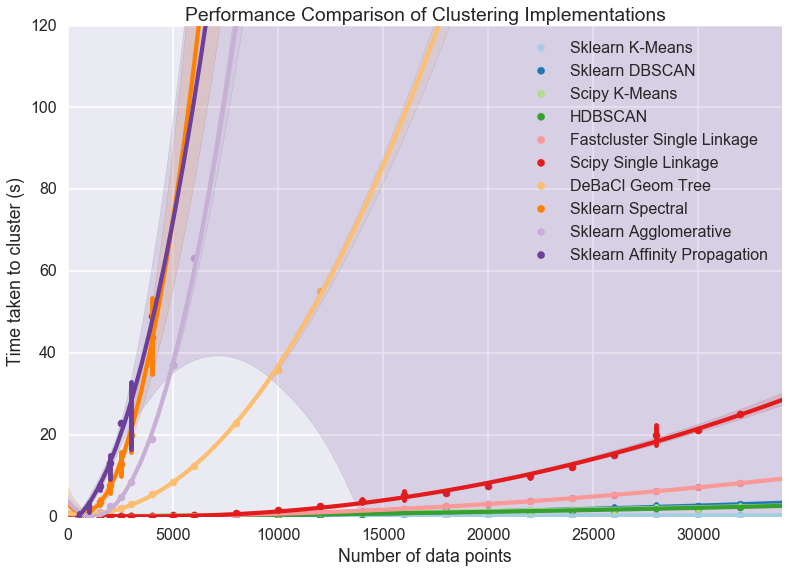

In [5]:
sns.regplot(x='x', y='y', data=k_means_data, order=2, 
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=dbscan_data, order=2, 
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_k_means_data, order=2, 
            label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=hdbscan_data, order=2, 
            label='HDBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=fastclust_data, order=2, 
            label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_single_data, order=2, 
            label='Scipy Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=debacl_data, order=2, 
            label='DeBaCl Geom Tree', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=spectral_data, order=2, 
            label='Sklearn Spectral', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=agg_data, order=2, 
            label='Sklearn Agglomerative', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=ap_data, order=2, 
            label='Sklearn Affinity Propagation', x_estimator=np.mean)
plt.gca().axis([0, 34000, 0, 120])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()

A few features stand out. First of all there appear to be essentially two classes of implementation, with DeBaCl being an odd case that falls in the middle. The fast implementations tend to be implementations of single linkage agglomerative clustering, K-means, and DBSCAN. The slow cases are largely from sklearn and include agglomerative clustering (in this case using Ward instead of single linkage).

For practical purposes this means that if you have much more than 10000 datapoints your clustering options are significantly constrained: sklearn spectral, agglomerative and affinity propagation are going to take far too long. DeBaCl may still be an option, but given that the hdbscan library provides "robust single linkage clustering" equivalent to what DeBaCl is doing (and with effectively the same runtime as hdbscan as it is a subset of that algorithm) it is probably not the best choice for large dataset sizes.

So let's drop out those slow algorithms so we can scale out a little further and get a closer look at the various algorithms that managed 32000 points in under thirty seconds. There is almost undoubtedly more to learn as we get ever larger dataset sizes.

## Comparison of fast implementations

Let's compare the six fastest implementations now. We can scale out a little further as well; based on the curves above it looks like we should be able to comfortably get to 60000 data points without taking much more than a minute per run. We can also note that most of these implementations weren't that noisy so we can get away with a single run per dataset size.

In [6]:
large_dataset_sizes = np.arange(1,16) * 4000

hdbscan_boruvka = hdbscan.HDBSCAN(algorithm='boruvka_kdtree')
large_hdbscan_boruvka_data = benchmark_algorithm(large_dataset_sizes, 
                                         hdbscan_boruvka.fit, (), {}, 
                                                 max_time=90, sample_size=1)

k_means = sklearn.cluster.KMeans(10)
large_k_means_data = benchmark_algorithm(large_dataset_sizes, 
                                         k_means.fit, (), {}, 
                                         max_time=90, sample_size=1)

dbscan = sklearn.cluster.DBSCAN(eps=1.25, min_samples=5)
large_dbscan_data = benchmark_algorithm(large_dataset_sizes, 
                                        dbscan.fit, (), {}, 
                                        max_time=90, sample_size=1)

large_fastclust_data = benchmark_algorithm(large_dataset_sizes, 
                                           fastcluster.linkage_vector, (), {}, 
                                           max_time=90, sample_size=1)

large_scipy_k_means_data = benchmark_algorithm(large_dataset_sizes, 
                                               scipy.cluster.vq.kmeans, (10,), {}, 
                                               max_time=90, sample_size=1)

large_scipy_single_data = benchmark_algorithm(large_dataset_sizes, 
                                              scipy.cluster.hierarchy.single, (), {}, 
                                              max_time=90, sample_size=1)

Again we can use seaborn to do curve fitting and plotting, exactly as before.

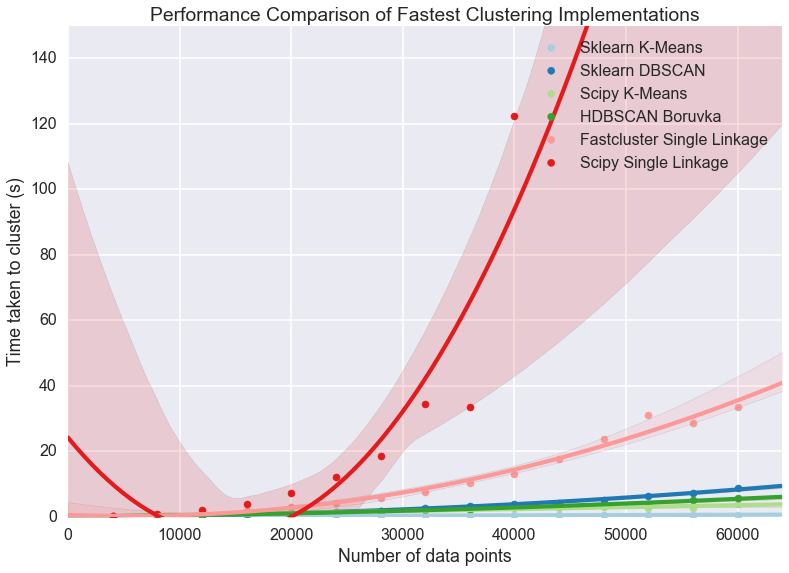

In [7]:
sns.regplot(x='x', y='y', data=large_k_means_data, order=2, 
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_dbscan_data, order=2, 
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_k_means_data, order=2, 
            label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_hdbscan_boruvka_data, order=2, 
            label='HDBSCAN Boruvka', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_fastclust_data, order=2, 
            label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_single_data, order=2, 
            label='Scipy Single Linkage', x_estimator=np.mean)

plt.gca().axis([0, 64000, 0, 150])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Fastest Clustering Implementations')
plt.legend()

Clearly something has gone woefully wrong with the curve fitting for the scipy single linkage implementation, but what exactly? If we look at the raw data we can see.

In [8]:
large_scipy_single_data.tail(10)

,x,y
5,24000.0,12.127519
6,28000.0,18.367958
7,32000.0,34.444517
8,36000.0,33.508459
9,40000.0,122.456995
10,44000.0,NaN
11,48000.0,NaN
12,52000.0,NaN
13,56000.0,NaN
14,60000.0,NaN


It seems that at around 44000 points we hit a wall and the runtimes spiked. A hint is that I'm running this on a laptop with 8GB of RAM. Both single linkage algorithms use `scipy.spatial.pdist` to compute pairwise distances between points, which returns an array of shape `(n(n-1)/2, 1)` of doubles. A quick computation shows that that array of distances is quite large once we nave 44000 points:

In [9]:
size_of_array = 44000 * (44000 - 1) / 2         # from pdist documentation
bytes_in_array = size_of_array * 8              # Since doubles use 8 bytes
gigabytes_used = bytes_in_array / (1024.0 ** 3)  # divide out to get the number of GB
gigabytes_used

7.211998105049133

If we assume that my laptop is keeping much other than that distance array in RAM then clearly we are going to spend time paging out the distance array to disk and back and hence we will see the runtimes increase dramatically as we become disk IO bound. If we just leave off the last element we can get a better idea of the curve, but keep in mind that the scipy single linkage implementation does not scale past a limit set by your available RAM.

/Users/leland/.conda/envs/hdbscan_dev/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


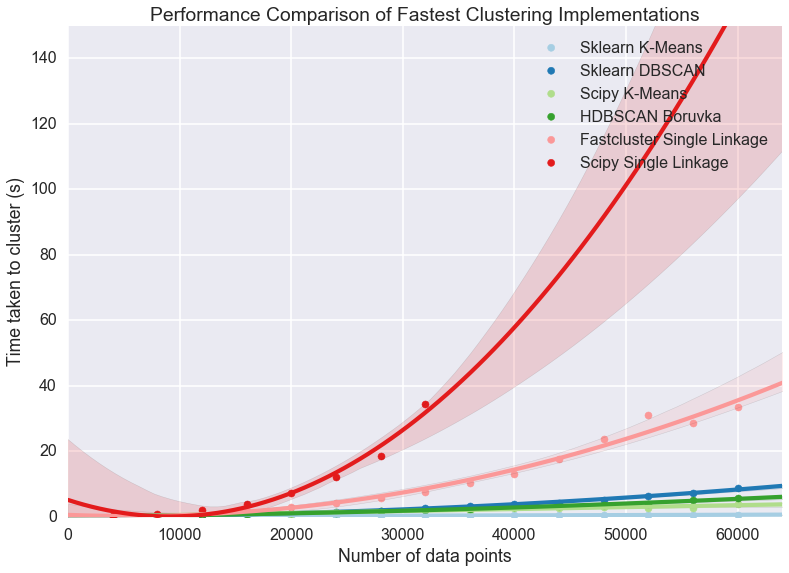

In [10]:
sns.regplot(x='x', y='y', data=large_k_means_data, order=2, 
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_dbscan_data, order=2, 
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_k_means_data, order=2, 
            label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_hdbscan_boruvka_data, order=2, 
            label='HDBSCAN Boruvka', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_fastclust_data, order=2, 
            label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=large_scipy_single_data[:8], order=2, 
            label='Scipy Single Linkage', x_estimator=np.mean)

plt.gca().axis([0, 64000, 0, 150])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Fastest Clustering Implementations')
plt.legend()

If we're looking for scaling we can write off the scipy single linkage implementation -- if even we didn't hit the RAM limit the $O(n^2)$ scaling is going to quickly catch up with us. Fastcluster has the same asymptotic scaling, but is heavily optimized to being the constant down much lower -- at this point it is still keeping close to the faster algorithms. It's asymtotics will still catch up with it eventually however.

In practice this is going to mean that for larger datasets you are going to be very constrained in what algorithms you can apply: if you get enough datapoints only K-Means, DBSCAN, and HDBSCAN will be left. This is somewhat disappointing, paritcularly as [K-Means is not a particularly good clustering algorithm](http://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb), paricularly for exploratory data analysis.

With this in mind it is worth looking at how these last several implementations perform at much larger sizes, to see, for example, when fastscluster starts to have its asymptotic complexity start to pull it away.

## Comparison of high performance implementations

At this point we can scale out to 200000 datapoints easily enough, so let's push things at least that far so we can start to really see scaling effects.

In [12]:
huge_dataset_sizes = np.arange(1,11) * 20000

k_means = sklearn.cluster.KMeans(10)
huge_k_means_data = benchmark_algorithm(huge_dataset_sizes, 
                                        k_means.fit, (), {}, 
                                        max_time=120, sample_size=2, dataset_dimension=10)

dbscan = sklearn.cluster.DBSCAN(eps=1.5)
huge_dbscan_data = benchmark_algorithm(huge_dataset_sizes, 
                                       dbscan.fit, (), {},
                                       max_time=120, sample_size=2, dataset_dimension=10)

huge_scipy_k_means_data = benchmark_algorithm(huge_dataset_sizes, 
                                              scipy.cluster.vq.kmeans, (10,), {}, 
                                              max_time=120, sample_size=2, dataset_dimension=10)

hdbscan_boruvka = hdbscan.HDBSCAN(algorithm='boruvka_kdtree')
huge_hdbscan_data = benchmark_algorithm(huge_dataset_sizes, 
                                       hdbscan_boruvka.fit, (), {}, 
                                        max_time=240, sample_size=4, dataset_dimension=10)

huge_fastcluster_data = benchmark_algorithm(huge_dataset_sizes, 
                                            fastcluster.linkage_vector, (), {}, 
                                            max_time=240, sample_size=2, dataset_dimension=10)

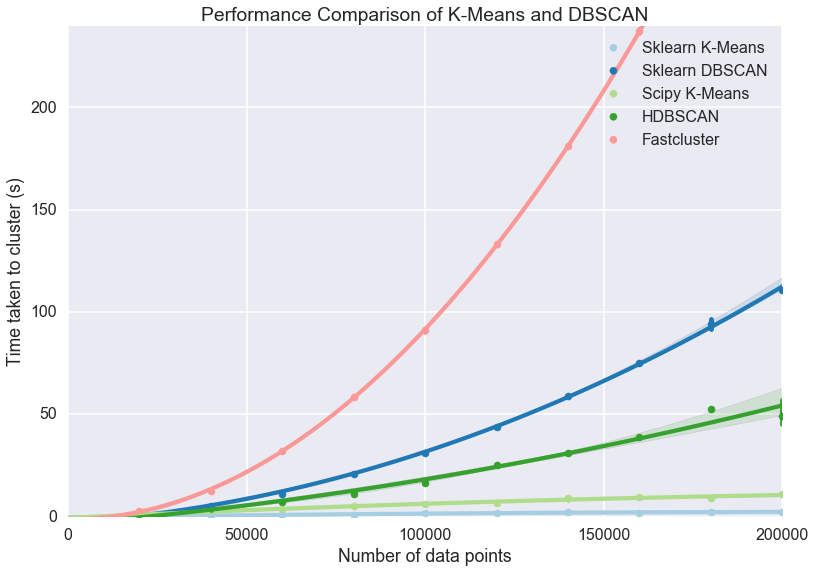

In [13]:
sns.regplot(x='x', y='y', data=huge_k_means_data, order=2, 
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=huge_dbscan_data, order=2, 
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=huge_scipy_k_means_data, order=2, 
            label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=huge_hdbscan_data, order=2, 
            label='HDBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=huge_fastcluster_data, order=2, 
            label='Fastcluster', x_estimator=np.mean)


plt.gca().axis([0, 200000, 0, 240])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of K-Means and DBSCAN')
plt.legend()

Now the some differences become clear. The asymptotic complexity starts to kick in with fastcluster failing to keep up. In turn HDBSCAN and DBSCAN, while having sub-$O(n^2)$ complexity, can't achieve $O(n \log(n))$ at this dataset dimension, and start to curve upward precipitously. Finally it demonstrates again how much of a difference implementation can make: the sklearn implementation of K-Means is far better than the scipy implementation. Since HDBSCAN clustering is a lot better than K-Means (unless you have good reasons to assume that the clusters partition your data and are all drawn from Gaussian distributions) and the scaling is still pretty good I would suggest that unless you have a truly stupendous amount of data you wish to cluster then the HDBSCAN implementation is a good choice.

## But should I get a coffee?

So we know which implementations scale and which don't; a more useful thing to know in practice is, given a dataset, what can I run interactively? What can I run while I go and grab some coffee? How about a run over lunch? What if I'm willing to wait until I get in tomorrow morning? Each of these represent significant breaks in productivity -- once you aren't working interactively anymore your productivity drops measurably, and so on.

We can build a table for this. To start we'll need to be able to approximate how long a given clustering implementation will take to run. Fortunately we already gathered a lot of that data; if we load up the `statsmodels` package we can fit the data (with a quadratic or $n\log n$ fit depending on the implementation; DBSCAN and HDBSCAN get caught here, since while they are under $O(n^2)$ scaling, they don't have an easily described model, so I'll model them as $n^2$ for now) and use the resulting model to make our predictions. Obviously this has some caveats: if you fill your RAM with a distance matrix your runtime isn't going to fit the curve.

I've hand built a `time_samples` list to give a reasonable set of potential data sizes that are nice and human readable. After that we just need a function to fit and build the curves.

In [14]:
import statsmodels.formula.api as sm

time_samples = [1000, 2000, 5000, 10000, 25000, 50000, 75000, 100000, 250000, 500000, 750000,
               1000000, 2500000, 5000000, 10000000, 50000000, 100000000, 500000000, 1000000000]

def get_timing_series(data, quadratic=True):
    if quadratic:
        data['x_squared'] = data.x**2
        model = sm.ols('y ~ x + x_squared', data=data).fit()
        predictions = [model.params.dot([1.0, i, i**2]) for i in time_samples]
        return pd.Series(predictions, index=pd.Index(time_samples))
    else: # assume n log(n)
        data['xlogx'] = data.x * np.log(data.x)
        model = sm.ols('y ~ x + xlogx', data=data).fit()
        predictions = [model.params.dot([1.0, i, i*np.log(i)]) for i in time_samples]
        return pd.Series(predictions, index=pd.Index(time_samples))

Now we run that for each of our pre-existing datasets to extrapolate out predicted performance on the relevant dataset sizes. A little pandas wrangling later and we've produced a table of roughly how large a dataset you can tackle in each time frame with each implementation. I had to leave out the scipy KMeans timings because the noise in timing results caused the model to be unrealistic at larger data sizes. Note how the $O(n\log n)$ algorithms utterly dominate here. In the meantime, for medium sizes data sets you can still get quite a lot done with HDBSCAN.

In [15]:
ap_timings = get_timing_series(ap_data)
spectral_timings = get_timing_series(spectral_data)
agg_timings = get_timing_series(agg_data)
debacl_timings = get_timing_series(debacl_data)
fastclust_timings = get_timing_series(large_fastclust_data.ix[:10,:].copy())
scipy_single_timings = get_timing_series(large_scipy_single_data.ix[:10,:].copy())
hdbscan_boruvka = get_timing_series(huge_hdbscan_data, quadratic=True)
#scipy_k_means_timings = get_timing_series(huge_scipy_k_means_data, quadratic=False)
dbscan_timings = get_timing_series(huge_dbscan_data, quadratic=True)
k_means_timings = get_timing_series(huge_k_means_data, quadratic=False)

timing_data = pd.concat([ap_timings, spectral_timings, agg_timings, debacl_timings, 
                            scipy_single_timings, fastclust_timings, hdbscan_boruvka, 
                            dbscan_timings, k_means_timings
                           ], axis=1)
timing_data.columns=['AffinityPropagation', 'Spectral', 'Agglomerative',
                                       'DeBaCl', 'ScipySingleLinkage', 'Fastcluster',
                                       'HDBSCAN', 'DBSCAN', 'SKLearn KMeans'
                                      ]
def get_size(series, max_time):
    return series.index[series < max_time].max()

datasize_table = pd.concat([
                            timing_data.apply(get_size, max_time=30),
                            timing_data.apply(get_size, max_time=300),
                            timing_data.apply(get_size, max_time=3600),
                            timing_data.apply(get_size, max_time=8*3600)
                            ], axis=1)
datasize_table.columns=('Interactive', 'Get Coffee', 'Over Lunch', 'Overnight')
datasize_table

,Interactive,Get Coffee,Over Lunch,Overnight
AffinityPropagation,2000,10000,25000,100000
Spectral,2000,5000,25000,75000
Agglomerative,2000,10000,25000,100000
DeBaCl,5000,25000,75000,250000
ScipySingleLinkage,25000,50000,100000,250000
Fastcluster,50000,100000,500000,1000000
HDBSCAN,100000,500000,1000000,5000000
DBSCAN,75000,250000,1000000,2500000
SKLearn KMeans,1000000000,1000000000,1000000000,1000000000


## Conclusions

Performance obviously depends on the algorithm chosen, but can also vary significantly upon the specific implementation (HDBSCAN is far better hierarchical density based clustering than DeBaCl, and sklearn has by far the best K-Means implementation). For anything beyond toy datasets, however, your algorithm options are greatly constrained. In my (obviously biased) opinion [HDBSCAN is the best algorithm for clustering](http://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb). If you need to cluster data beyond the scope that HDBSCAN can reasonably handle then the only algorithm options on the table are DBSCAN and K-Means; DBSCAN is the slower of the two, especially for very large data, but K-Means clustering can be remarkably poor -- it's a tough choice.